# Jigsaw Puzzle — Milestone 1 Pipeline

This notebook implements a full Milestone-1 pipeline for the puzzle dataset located at `/mnt/data/1.jpg`.

**Features implemented:**
- Automatic grid detection (projection profiles) with fallback to manual grid size
- Tile extraction for 2x2, 4x4, 8x8 puzzles
- Per-tile enhancement (denoise, CLAHE, optional resize)
- Binary mask creation and contour extraction
- Artifacts saving (enhanced images, masks, contours, metadata)
- Visualization helpers (before/after and grid overlay)

Run each cell in order. Modify parameters near the top if needed.


In [15]:

# Imports and parameters
import cv2, os, json, numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

INPUT_PATH = "D:/Image-Processing-Project/Gravity_Falls/puzzle_2x2/0.jpg"   # representative image
OUT_DIR = "D:/Image-Processing-Project/output"
os.makedirs(OUT_DIR, exist_ok=True)
os.makedirs(os.path.join(OUT_DIR,"tiles"), exist_ok=True)
os.makedirs(os.path.join(OUT_DIR,"visualizations"), exist_ok=True)

# Parameters (tweak if needed)
FALLBACK_GRID = None   # set to (rows,cols) if auto-detect fails, e.g. (4,4)
PADDING = 4            # pixels to include around tiles when cropping
RESIZE_TO = None       # set e.g. (256,256) to resize tiles for uniformity, or None to keep original
SAVE_CONTOUR_NPY = True


In [16]:

def show(img, title="", figsize=(6,6)):
    plt.figure(figsize=figsize)
    if len(img.shape)==2:
        plt.imshow(img, cmap='gray')
    else:
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.axis('off')

# quick save helper
def imwrite(path, img):
    cv2.imwrite(path, img)


Image size: 224 x 224


True

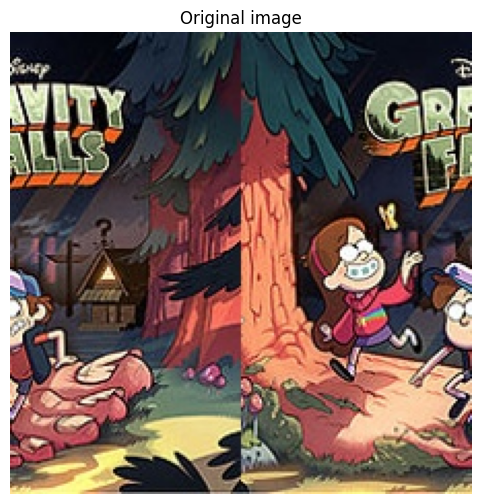

In [17]:

img_bgr = cv2.imread(INPUT_PATH)
if img_bgr is None:
    raise FileNotFoundError(f"Input image not found: {INPUT_PATH}")
h,w = img_bgr.shape[:2]
print("Image size:", w, "x", h)
show(img_bgr, "Original image")
cv2.imwrite(os.path.join(OUT_DIR,"original.jpg"), img_bgr)


Auto-detection candidates: [2, 4, 8]


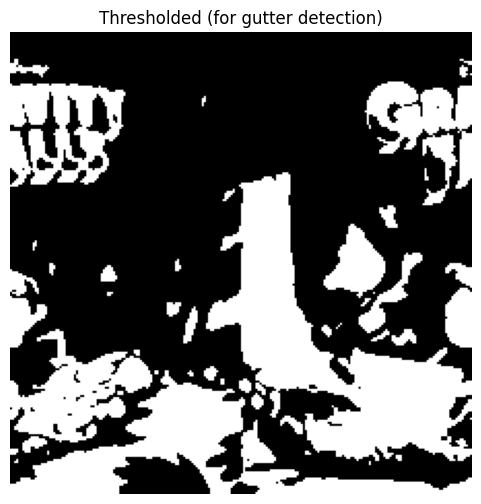

In [18]:

def detect_grid_via_projections(img_gray, max_candidates=(2,4,8)):
    # We expect dark gutters between tiles; threshold to highlight gutters
    # Use adaptive threshold to be robust to lighting
    blur = cv2.GaussianBlur(img_gray, (5,5), 0)
    _, th = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    # invert so gutters (dark) become white in inverted image? We'll detect minima in projection.
    proj_h = np.mean(th, axis=1)       # across cols -> rows profile
    proj_v = np.mean(th, axis=0)       # across rows -> cols profile
    
    # Smooth profiles
    from scipy.signal import find_peaks
    ph = cv2.GaussianBlur(proj_h.astype(np.float32), (1,9), 0).flatten()
    pv = cv2.GaussianBlur(proj_v.astype(np.float32), (9,1), 0).flatten()
    
    # Normalize and invert so gutters (dark lines) show as peaks
    phn = (ph.max()-ph) / (ph.max()-ph.min()+1e-9)
    pvn = (pv.max()-pv) / (pv.max()-pv.min()+1e-9)
    
    results = {}
    for candidate in max_candidates:
        # we expect candidate-1 gutter lines vertically and horizontally
        expected_gutters = candidate-1
        # find peaks
        peaks_h, _ = find_peaks(phn, height=0.3, distance=10)
        peaks_v, _ = find_peaks(pvn, height=0.3, distance=10)
        # If peaks count matches expected, compute tile coords
        if len(peaks_h) >= expected_gutters and len(peaks_v) >= expected_gutters:
            # use quantization: cluster peaks into expected_gutters highest peaks
            ph_sorted = peaks_h[np.argsort(phn[peaks_h])[-expected_gutters:]]
            pv_sorted = peaks_v[np.argsort(pvn[peaks_v])[-expected_gutters:]]
            ph_sorted = np.sort(ph_sorted)
            pv_sorted = np.sort(pv_sorted)
            results[candidate] = (ph_sorted.tolist(), pv_sorted.tolist())
    return results, th

# Run detection
import numpy as np
gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
results, th = detect_grid_via_projections(gray)
print('Auto-detection candidates:', list(results.keys()))
show(th, "Thresholded (for gutter detection)")


In [19]:

def compute_grid_from_gutters(img_shape, gutter_rows, gutter_cols):
    h, w = img_shape[:2]
    # gutters are positions of lines between tiles. Assume they are between tiles.
    # Add image boundaries as virtual gutters at -0.5 and end+0.5 for easier tile bbox calculation.
    gr = [ -0.5 ] + [float(p) for p in gutter_rows] + [ h-0.5 ]
    gc = [ -0.5 ] + [float(p) for p in gutter_cols] + [ w-0.5 ]
    rows = len(gr)-1
    cols = len(gc)-1
    bboxes = []
    for r in range(rows):
        for c in range(cols):
            y0 = int(max(0, np.floor(gr[r]+1)))
            y1 = int(min(h, np.ceil(gr[r+1]-1)))
            x0 = int(max(0, np.floor(gc[c]+1)))
            x1 = int(min(w, np.ceil(gc[c+1]-1)))
            bboxes.append(((r,c),(x0,y0,x1,y1)))
    return rows, cols, bboxes

# Choose grid from detection or fallback
if results:
    # pick best candidate (largest candidate keys present)
    candidate = max(results.keys())
    gutter_rows, gutter_cols = results[candidate]
    # Expand gutters by half the gap between adjacent gutters to get proper tile boxes
    # For simplicity, compute tile size by dividing image by candidate
    rows, cols = candidate, candidate
    # compute tile widths & heights evenly
    tile_h = h // rows
    tile_w = w // cols
    bboxes = []
    for r in range(rows):
        for c in range(cols):
            x0 = c*tile_w
            y0 = r*tile_h
            x1 = (c+1)*tile_w if c<cols-1 else w
            y1 = (r+1)*tile_h if r<rows-1 else h
            bboxes.append(((r,c),(x0,y0,x1,y1)))
    print("Using auto-detected grid:", rows, "x", cols)
else:
    if FALLBACK_GRID is not None:
        rows, cols = FALLBACK_GRID
        tile_h = h // rows
        tile_w = w // cols
        bboxes = []
        for r in range(rows):
            for c in range(cols):
                x0 = c*tile_w
                y0 = r*tile_h
                x1 = (c+1)*tile_w if c<cols-1 else w
                y1 = (r+1)*tile_h if r<rows-1 else h
                bboxes.append(((r,c),(x0,y0,x1,y1)))
        print("Using fallback grid:", rows, "x", cols)
    else:
        # Fallback simple heuristic: try 2x2,4x4,8x8 and choose the one with lowest average edge variance inside tiles
        candidates = [2,4,8]
        best=None; best_score=1e9
        for candidate in candidates:
            tile_h = h // candidate; tile_w = w // candidate
            scores = []
            for r in range(candidate):
                for c in range(candidate):
                    x0 = c*tile_w; y0 = r*tile_h
                    x1 = (c+1)*tile_w if c<candidate-1 else w
                    y1 = (r+1)*tile_h if r<candidate-1 else h
                    crop = gray[y0:y1, x0:x1]
                    scores.append(np.std(crop))
            score = np.mean(scores)
            if score < best_score:
                best_score = score; best = candidate
        rows, cols = best, best
        tile_h = h // rows; tile_w = w // cols
        bboxes = []
        for r in range(rows):
            for c in range(cols):
                x0 = c*tile_w; y0 = r*tile_h
                x1 = (c+1)*tile_w if c<cols-1 else w
                y1 = (r+1)*tile_h if r<rows-1 else h
                bboxes.append(((r,c),(x0,y0,x1,y1)))
        print("Using heuristic grid:", rows, "x", cols)

# Save grid info
grid_info = {"rows": rows, "cols": cols, "image_size": [int(w), int(h)], "num_tiles": len(bboxes)}
with open(os.path.join(OUT_DIR,"grid.json"), "w") as f:
    json.dump(grid_info, f, indent=2)
print("Grid boxes:", len(bboxes))


Using auto-detected grid: 8 x 8
Grid boxes: 64


Saved 64 tiles to D:/Image-Processing-Project/output\tiles


Text(0.5, 0.98, 'Tile originals')

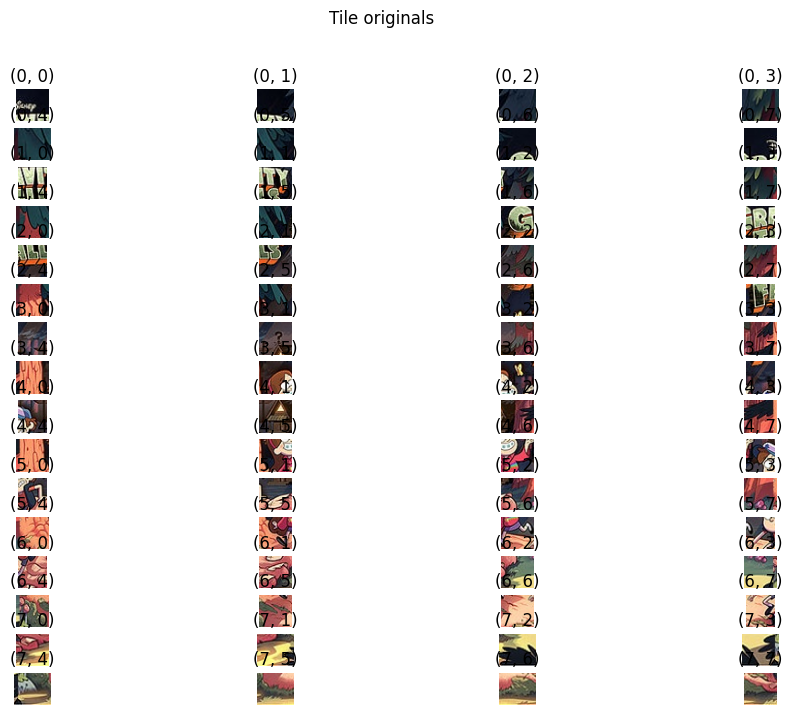

In [20]:

# Extract tiles with padding, save originals
tiles = []
for (r,c),(x0,y0,x1,y1) in bboxes:
    xx0 = max(0, x0-PADDING); yy0 = max(0, y0-PADDING)
    xx1 = min(w, x1+PADDING); yy1 = min(h, y1+PADDING)
    crop = img_bgr[yy0:yy1, xx0:xx1].copy()
    tiles.append({"rc":(r,c), "bbox":(xx0,yy0,xx1,yy1), "img":crop})
    fname = os.path.join(OUT_DIR,"tiles", f"tile_r{r}_c{c}_orig.png")
    imwrite(fname, crop)
print("Saved", len(tiles), "tiles to", os.path.join(OUT_DIR,"tiles"))
# show a small mosaic of originals
cols_disp = min(cols,4)
rows_disp = (len(tiles)+cols_disp-1)//cols_disp
plt.figure(figsize=(12,8))
for i,t in enumerate(tiles):
    plt.subplot(rows_disp, cols_disp, i+1)
    img_plot = cv2.cvtColor(t["img"], cv2.COLOR_BGR2RGB)
    plt.imshow(img_plot); plt.axis('off'); plt.title(f"{t['rc']}")
plt.suptitle("Tile originals")


In [21]:

# Enhancement helpers
def enhance_tile(tile_bgr, resize_to=None):
    # Convert to LAB and apply CLAHE on L channel
    lab = cv2.cvtColor(tile_bgr, cv2.COLOR_BGR2LAB)
    l,a,b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    cl = clahe.apply(l)
    limg = cv2.merge((cl,a,b))
    enhanced = cv2.cvtColor(limg, cv2.COLOR_LAB2BGR)
    # Denoise - bilateral preserves edges
    den = cv2.bilateralFilter(enhanced, d=9, sigmaColor=75, sigmaSpace=75)
    # Optional resize
    if resize_to is not None:
        den = cv2.resize(den, resize_to, interpolation=cv2.INTER_AREA)
    return den

def tile_to_mask(tile_bgr):
    # Create mask of foreground (non-background) — useful if tiles have padding/backdrop
    gray = cv2.cvtColor(tile_bgr, cv2.COLOR_BGR2GRAY)
    # Try adaptive threshold then morphological operations to clean mask
    th = cv2.adaptiveThreshold(gray,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                               cv2.THRESH_BINARY_INV,11,2)
    # Morphological open to remove small noise, then close to fill holes
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(5,5))
    cleaned = cv2.morphologyEx(th, cv2.MORPH_OPEN, kernel, iterations=1)
    cleaned = cv2.morphologyEx(cleaned, cv2.MORPH_CLOSE, kernel, iterations=2)
    # Keep largest contour
    contours, _ = cv2.findContours(cleaned, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        return cleaned
    largest = max(contours, key=cv2.contourArea)
    mask = np.zeros_like(cleaned)
    cv2.drawContours(mask, [largest], -1, 255, -1)
    return mask

def extract_contour_from_mask(mask):
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    if not contours:
        return None
    largest = max(contours, key=cv2.contourArea)
    return largest.squeeze()


In [22]:

artifact_list = []
for t in tiles:
    r,c = t["rc"]
    tile = t["img"]
    enhanced = enhance_tile(tile, resize_to=RESIZE_TO)
    mask = tile_to_mask(enhanced)
    contour = extract_contour_from_mask(mask)
    # save artifacts
    base = os.path.join(OUT_DIR,"tiles", f"tile_r{r}_c{c}")
    imwrite(base+"_enhanced.png", enhanced)
    imwrite(base+"_mask.png", mask)
    if SAVE_CONTOUR_NPY and contour is not None and contour.ndim==2:
        np.save(base+"_contour.npy", contour)
    meta = {"rc":(int(r),int(c)), "bbox":t["bbox"], "contour_exists": bool(contour is not None)}
    with open(base+"_meta.json","w") as f: json.dump(meta,f)
    artifact_list.append(meta)

print("Processed and saved artifacts for", len(artifact_list), "tiles.")


Processed and saved artifacts for 64 tiles.


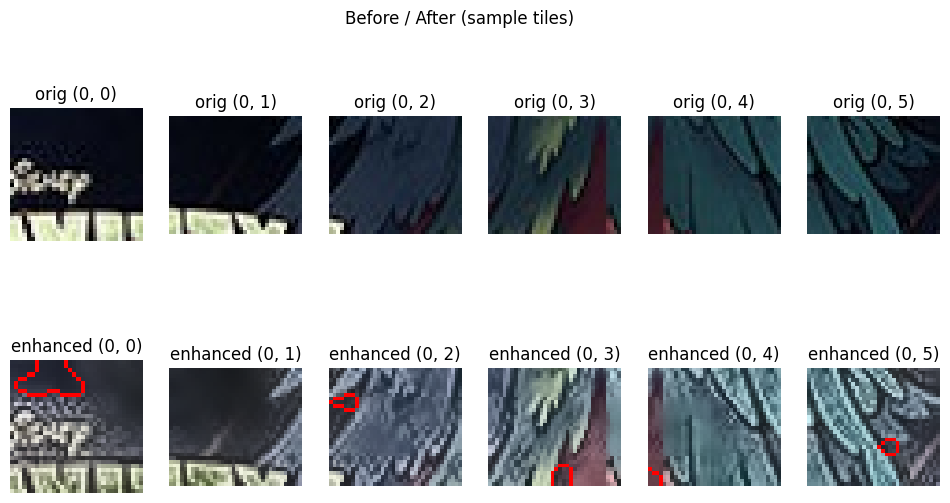

In [23]:

# Show few tiles before/after and overlay contour
num_show = min(6, len(tiles))
plt.figure(figsize=(12,6))
for i in range(num_show):
    tile = tiles[i]["img"]
    enhanced = cv2.imread(os.path.join(OUT_DIR,"tiles", f"tile_r{tiles[i]['rc'][0]}_c{tiles[i]['rc'][1]}_enhanced.png"))
    mask = cv2.imread(os.path.join(OUT_DIR,"tiles", f"tile_r{tiles[i]['rc'][0]}_c{tiles[i]['rc'][1]}_mask.png"),0)
    plt.subplot(2,num_show,i+1)
    plt.imshow(cv2.cvtColor(tile, cv2.COLOR_BGR2RGB)); plt.axis('off'); plt.title(f"orig {tiles[i]['rc']}")
    plt.subplot(2,num_show,num_show+i+1)
    if enhanced is not None:
        disp = cv2.cvtColor(enhanced, cv2.COLOR_BGR2RGB)
        if mask is not None:
            # overlay mask edges
            edges = cv2.Canny(mask,50,150)
            disp[edges>0] = (255,0,0)
        plt.imshow(disp)
    plt.axis('off'); plt.title(f"enhanced {tiles[i]['rc']}")
plt.suptitle("Before / After (sample tiles)")
plt.savefig(os.path.join(OUT_DIR,"visualizations","before_after_sample.png"))


True

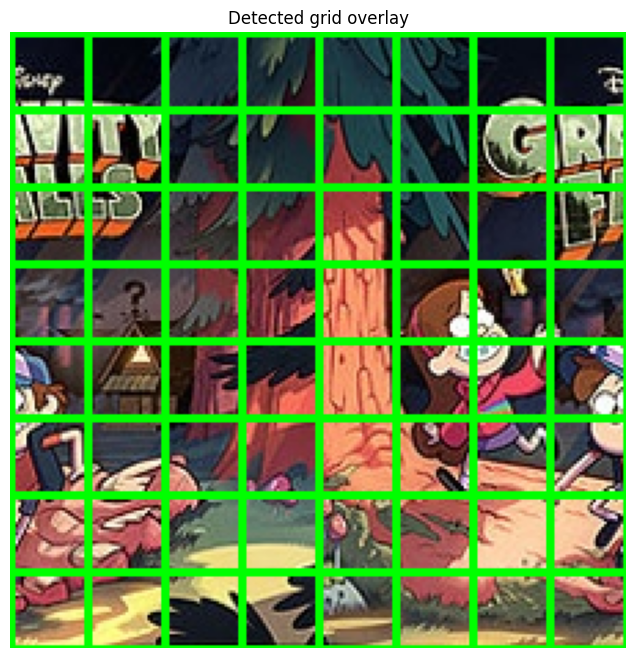

In [24]:

# Draw grid overlay on original image
overlay = img_bgr.copy()
for (r,c),(x0,y0,x1,y1) in bboxes:
    cv2.rectangle(overlay, (x0,y0), (x1,y1), (0,255,0), 2)
show(overlay, "Detected grid overlay", figsize=(8,8))
cv2.imwrite(os.path.join(OUT_DIR,"visualizations","grid_overlay.png"), overlay)


## Summary

The pipeline above:
- Loads the image `/mnt/data/1.jpg`.
- Attempts automatic grid detection and falls back to heuristics if needed.
- Extracts tiles, enhances them with CLAHE + bilateral filtering.
- Generates masks and extracts contours (saved as `.npy`).
- Saves artifacts under `/mnt/data/outputs_image_1/`.

**Next steps for Milestone 2 (not implemented here):**
- Extract edge descriptors from contours (Fourier, curvature, shape context).
- Implement rotation-invariant matching between tile edges.
- Visualize candidate matches and assemble puzzle.
